# Going Deeper 04
## 프로젝트: 자율주행 보조 시스템 만들기

### 프로젝트 구성
1. 자율주행 시스템 만들기
2. 자율주행 시스템 평가하기

### 프로젝트 목표
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
    - KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2.  RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.
    - 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성
    - 테스트 수행결과 90% 이상의 정확도를 목표

## 1. KITTI 데이터셋 확인
### 1.1 KITTI 데이터셋

KITTI는 2012년 3월에 공개된 오픈 데이터 및 benchmark로 WAYMO나 nuScenes와 달리 직접 다운 받아야 하는 데이터셋입니다. 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공합니다.

1. class 종류
    - Car, Van, Truck, Pedestrians, Sitters, Cyclists, Trams, Misc

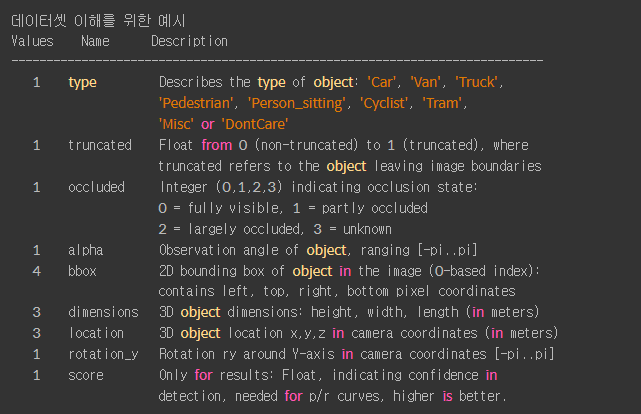

2. 데이터 수집 센서
    - GPS 1개
    - LiDAR 1개
    - 흑백 카메라 2개
    - 컬러 카메라 2개
    
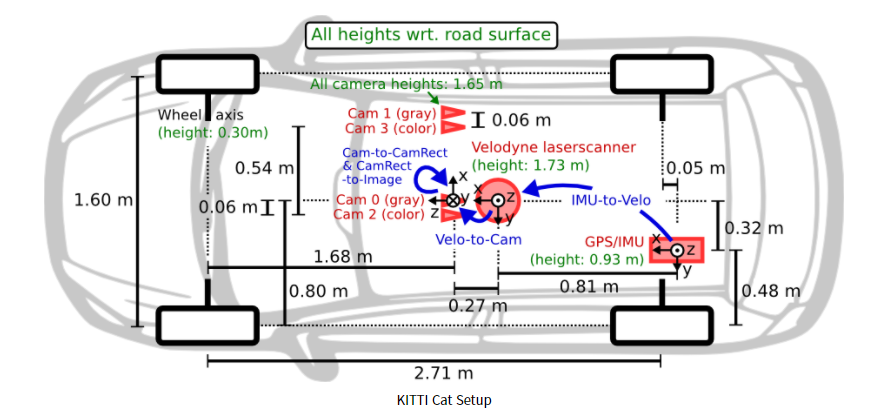

In [36]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('슝💨')

슝💨


In [37]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir = data_dir,
    split=['train', 'test'],
    shuffle_files = True,
    with_info = True
)

print('슝💨')

슝💨


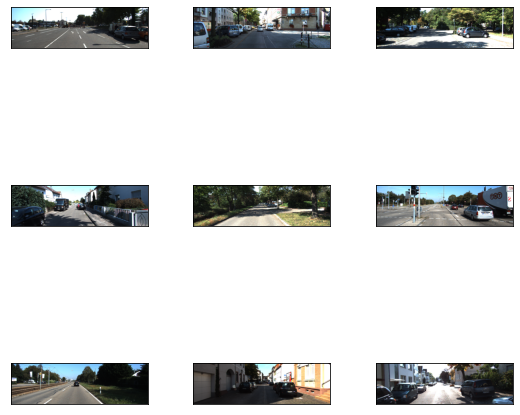

In [38]:
_ = tfds.show_examples(ds_train, ds_info)

In [39]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 1.2 데이터 직접 확인하기

In [40]:
sample = ds_train.take(1)

-----Example-----
['image', 'image/file_name', 'objects']
-----object-----
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.59, -1.27,  1.98], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.13370667, 0.4452818 , 0.54328   , 0.5736312 ],
       [0.45808   , 0.26686797, 0.53104   , 0.28133655],
       [0.38605332, 0.19425926, 0.5087467 , 0.27665058]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.66, 1.73, 3.05],
       [1.78, 0.6 , 1.81],
       [1.47, 1.72, 4.39]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[  0.2 ,   1.67,   9.42],
       [-17.93,   1.99,  47.94],
       [-11.3 ,   1.9 ,  25.94]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.57, -1.63,  1.58], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=arra

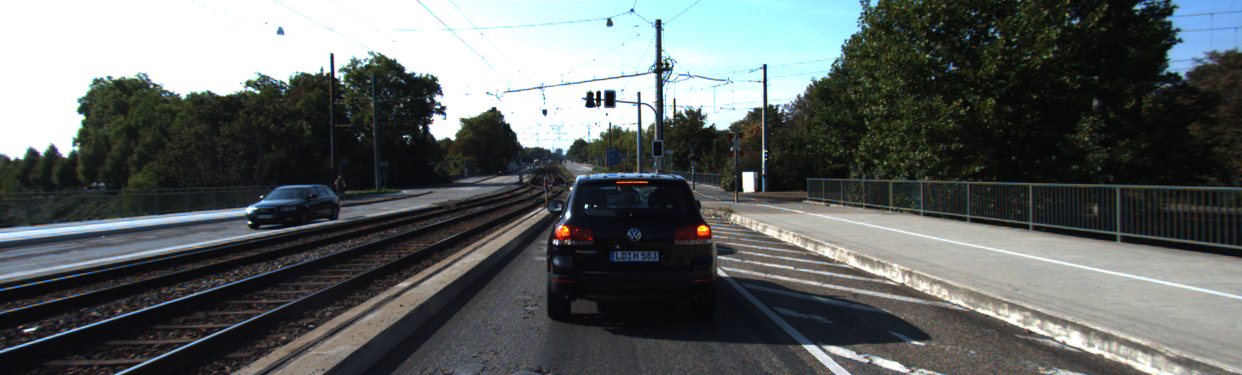

In [41]:
for example in sample:
    print('-----Example-----')
    print(list(example.keys())) # example is '{'image': tf.Tensor, 'label': tf.Tensor}'
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']

    
print('-----object-----')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242 height: 375
(3, 4)
[553.04 324.86 712.45 171.27]
[331.45    203.22    349.41998 175.86   ]
[241.26999 230.23001 343.6     184.22   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7EFB740E61D0>


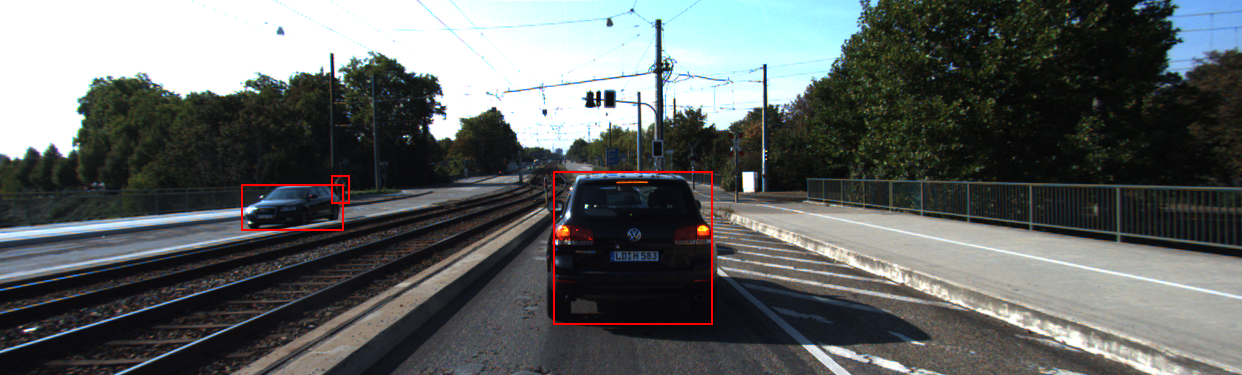

In [42]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, 'height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    # Draw Bounding Box
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255, 0, 0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())    

## 2. 데이터 포맷 변경
- Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet
- 현재는 텐서플로우 2 버전을 지원하는 리포지토리(repository)도 만들어졌으나 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있음
- 따라서 Keras RetineNet 리포지토리를 이용

tensorflow_dataset의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 합니다. 하지만 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법이 있습니다.

### 1) 클래스 및 바운딩 박스 정보 추출
- 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성
- 브레이크 시스템을 만드는 것이므로 차와 사람을 구분해야 함

In [60]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [23:17<00:00,  4.54it/s] 


In [61]:
# 테스트 데이터셋에도 동일 과정 적용
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.56it/s]


### 2) 클래스 맵핑
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야, 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

In [62]:
class_txt_path = data_dir+'/classes.txt'

def save_class_format(path):
    class_type_map = {
        'car':0,
        'person':1        
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k,v in class_type_map.items():
            f.write(f'{k},{v}/n')
    print('Done')
    
save_class_format(class_txt_path)        

Done


## 3. keras-retinanet 실습 - 셋팅
- 변환한 데이터셋으로 학습 진행
- 환경에 따라 batch_size, worker, epoch 조절

In [63]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다.
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-10-18 06:39:41.393153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 06:39:43.224018: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-18 06:39:43.225129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-18 06:39:43.233302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-18 06:39:43.233338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 06:39:43.236357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-18

In [64]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-18 06:39:45.114208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 06:39:46.709861: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-18 06:39:46.710889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-18 06:39:46.718831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-18 06:39:46.719054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 06:39:46.722231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-18

## 4. keras-retinanet 실습 - 시각화

In [71]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [125]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path,visualize=True):
    image = read_image_bgr(img_path)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0 : (0,0,255), # blue
        1: (255, 0, 0) # red
    }
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.4:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        
        plt.figure(figsize=(15,15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

[195.13264 135.43787 343.16095 233.24002]
[594.8718  174.33887 625.566   207.38184]
[375.52695 183.27113 416.44852 211.12585]
[531.9987  158.62715 564.2143  192.11226]
[441.81308 171.19206 474.8509  200.08693]
[247.53374 130.66945 363.11734 220.4601 ]


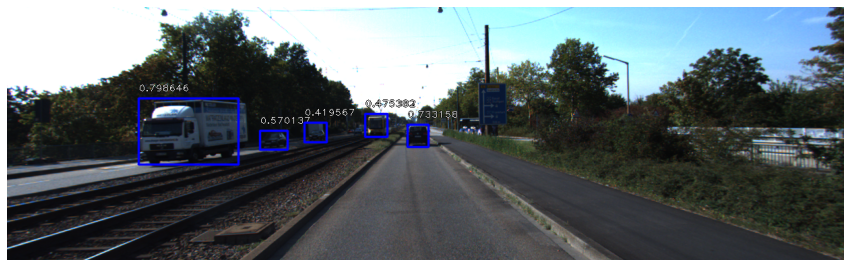

In [126]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
inference_on_image(model, img_path)

[769.0767  151.903   846.4445  322.41837]
[748.3236  140.02048 827.91223 297.6212 ]


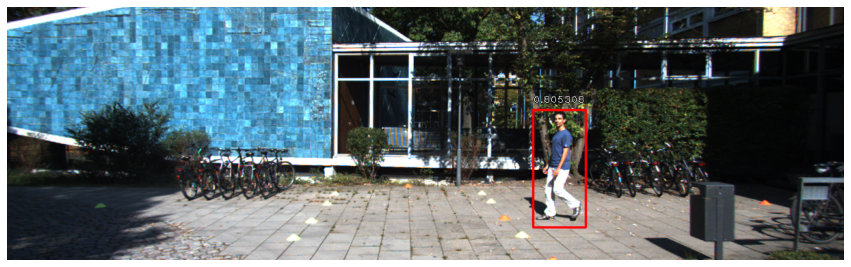

In [127]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 5. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수 만들기

1. 입력으로 이미지 경로를 받습니다.
2. 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
3. 조건
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [128]:
# inference_on_image 함수를 구현해 주세요.
def self_drive_assist(img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)
    # 코드 구현
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0 : (0,0,255), # blue
        1: (255, 0, 0) # red
    }
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.4:
                break
            b = box.astype(int)
            width = b[2]-b[0]
            height = b[3]-b[1]
            
            if width >= size_limit or height >= size_limit or label ==1:
                # 차량의 크기(width or height)가 300px 이상이거나 label이 사람일 때
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
        
    return result

[418.46793 172.51302 499.5906  337.6084 ]
[435.1546  158.4122  490.70038 279.50443]


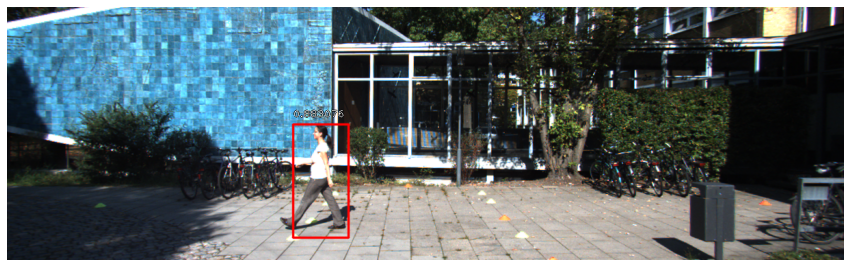

'Stop'

In [129]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'
self_drive_assist(img_path=img_path)

## 6. 자율주행 시스템 평가하기

아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [130]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"결과: {score}점입니다.")

[769.0767  151.903   846.4445  322.41837]
[748.3236  140.02048 827.91223 297.6212 ]


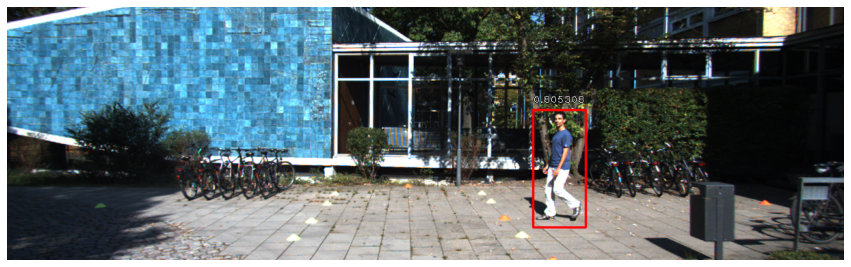

test_set/stop_1.png
prediction: Stop, answer: Stop

[418.46793 172.51302 499.5906  337.6084 ]
[435.1546  158.4122  490.70038 279.50443]


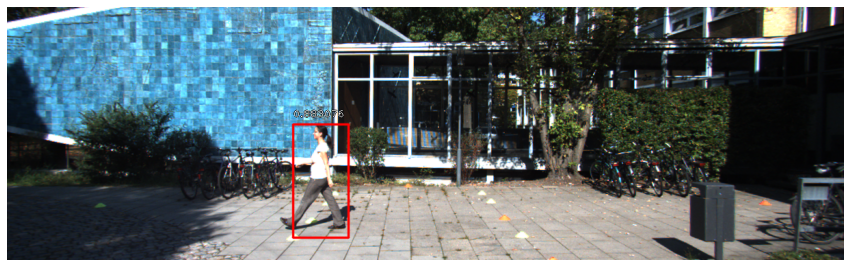

test_set/stop_2.png
prediction: Stop, answer: Stop

[  0.      202.45717 278.50034 369.12827]
[760.1729  160.01036 873.62866 209.10803]
[1000.3721   146.84381 1040.8004   220.14275]
[ 988.0937   147.00212 1024.1964   218.67221]


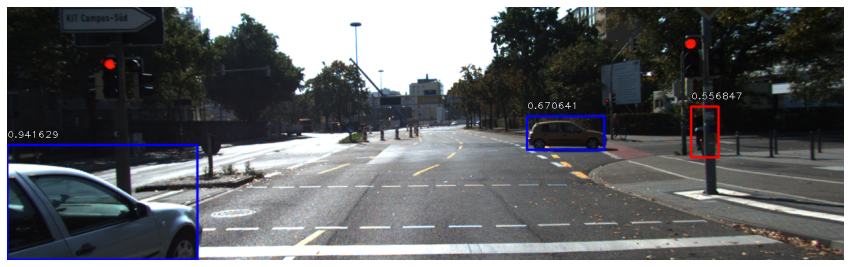

test_set/stop_3.png
prediction: Stop, answer: Stop

[656.79083 142.0497  739.51764 226.15138]
[440.4288  156.22404 552.0953  209.72023]
[ 730.4765    88.50175 1096.6365   353.91193]
[ 80.87463 155.04106 348.7843  305.13998]
[361.86816 168.43547 468.61047 216.0758 ]
[681.0186  156.28807 775.9999  242.32936]
[389.36932 164.19987 530.9678  216.88335]
[699.6845  164.25937 809.55035 259.72476]


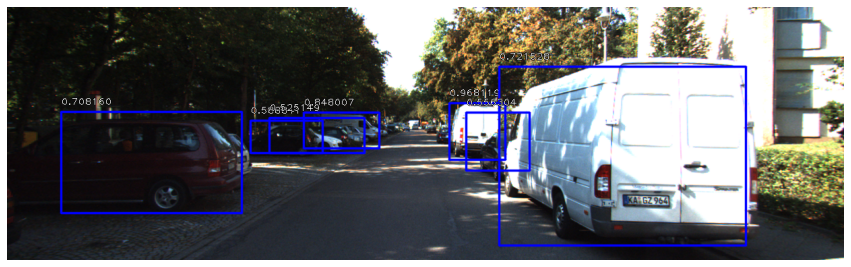

test_set/stop_4.png
prediction: Go, answer: Stop

[699.85443 141.08536 780.9173  219.742  ]
[ 886.08435  177.73885 1241.0684   373.6249 ]
[738.42377 160.74962 850.649   249.77092]
[566.6818  180.41696 617.9651  215.84456]
[711.27466 147.54182 824.195   234.68762]
[ 901.7479   190.66414 1107.4666   353.8687 ]
[1027.5625   137.8143  1233.4127   337.07486]


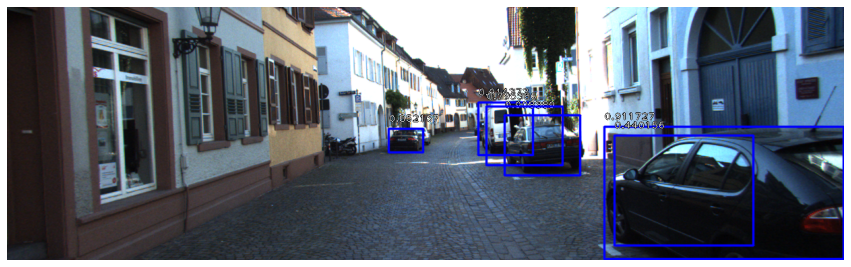

test_set/stop_5.png
prediction: Go, answer: Stop

[195.13264 135.43787 343.16095 233.24002]
[594.8718  174.33887 625.566   207.38184]
[375.52695 183.27113 416.44852 211.12585]
[531.9987  158.62715 564.2143  192.11226]
[441.81308 171.19206 474.8509  200.08693]
[247.53374 130.66945 363.11734 220.4601 ]


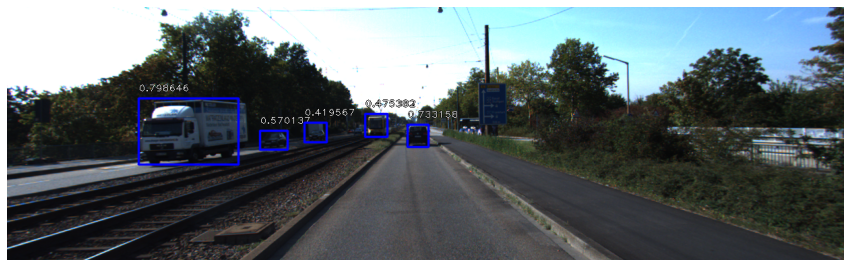

test_set/go_1.png
prediction: Go, answer: Go

[517.99384 179.63461 566.7382  214.50404]
[629.13855 175.8396  669.8585  214.6149 ]
[529.06024 174.95241 577.8858  209.3786 ]


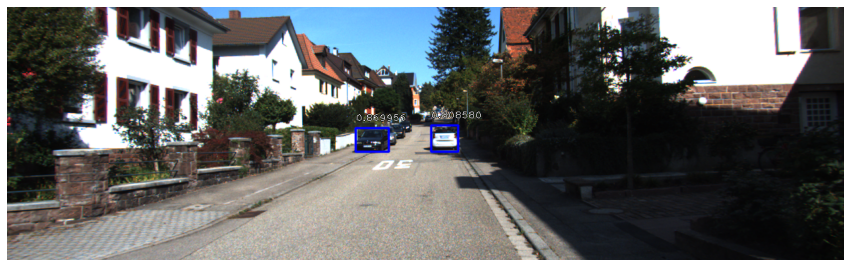

test_set/go_2.png
prediction: Go, answer: Go

[540.7176  166.11269 569.89087 191.98909]


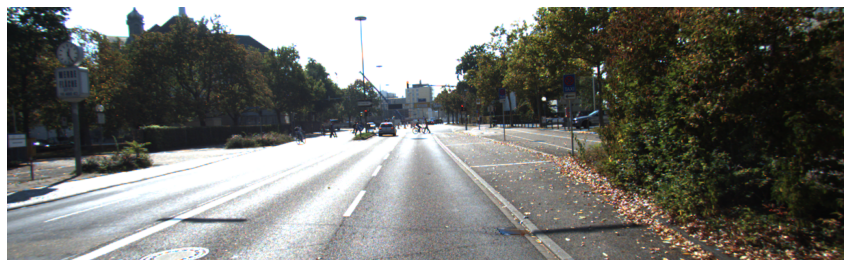

test_set/go_3.png
prediction: Go, answer: Go

[699.2908  162.93431 792.1393  253.81995]
[702.9841  161.3036  779.93335 255.04811]


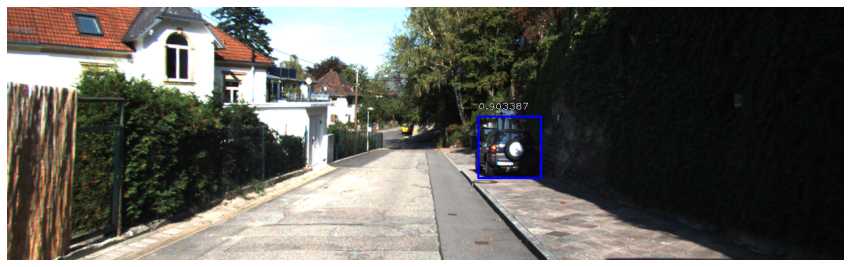

test_set/go_4.png
prediction: Go, answer: Go

[1.7995849e-01 1.8226636e+02 2.0452072e+02 3.0396848e+02]
[169.13448 181.11234 337.47015 253.24515]
[440.37964 179.47986 490.05225 211.64868]
[220.29494 176.08177 368.50995 242.43849]
[103.39877 182.97466 290.02988 264.52667]
[268.4601  174.4687  395.12656 229.27733]
[328.8514  174.27797 425.0573  224.25267]
[1098.6437   141.13535 1234.1028   200.27347]


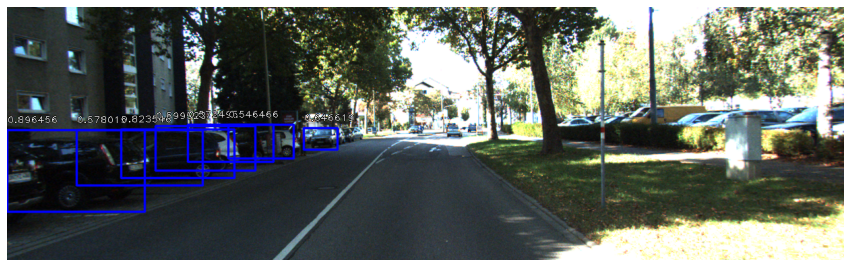

test_set/go_5.png
prediction: Go, answer: Go

결과: 80점입니다.


In [131]:
test_system(self_drive_assist)

## 프로젝트 정리

- self_drive_assist() 함수를 구현할 때, default 리턴 값을 'Go'로 설정하였다.
- 자동차는 기본적으로 주행을 하는 것을 기본 조건으로 하되, 정지 조건을 만족하는 상황에선 'Stop'을 리턴하도록 구현했다.
- 정지 조건은 차량의 크기(width or height)가 300px 이상이거나 label이 사람일 때로 설정하였음
- score < 0.45로 설정했을 때, test_set/stop_4.png, test_set/stop_5.png 2장을 틀리게 예측하여 80점이 나왔다.
- 이후 score threshold 값을 0.4로 낮추고 다시 테스트하였음에도 점수는 80점을 유지했다.